# Fetch Senior Data Analyst Take Home Assessment 

## STEP 1 : EXPLORING DATA¶
USER DATA

In [2]:
#Importing necessary libraries 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
#Load the User DataSet
users = pd.read_csv('/Users/saiprakashmadderla/fetch-data-analyst-assessment/data/users.csv')

In [4]:
#Display basic info about the dataset
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ID            100000 non-null  object
 1   CREATED_DATE  100000 non-null  object
 2   BIRTH_DATE    96325 non-null   object
 3   STATE         95188 non-null   object
 4   LANGUAGE      69492 non-null   object
 5   GENDER        94108 non-null   object
dtypes: object(6)
memory usage: 4.6+ MB


,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female


In [5]:
# Analyze missing values 
missing_values = users.isnull().sum()
missing_values

ID                  0
CREATED_DATE        0
BIRTH_DATE       3675
STATE            4812
LANGUAGE        30508
GENDER           5892
dtype: int64

#### Data Quality Issues – Missing Values

The dataset has notable missing values:
1. BIRTH_DATE: 3,675 missing records, impacting age-based analysis.
2. STATE: 4,812 missing records, affecting location analysis.
3. LANGUAGE: 30,508 missing records, hindering language preference analysis.
4. GENDER: 5,892 missing records, limiting demographic insights.

Addressing these missing values will be crucial for accurate analysis and decision-making.

In [6]:
#Check for duplicate user IDs
duplicates = users['ID'].duplicated().sum()
print(f'Number of duplicate user IDs: {duplicates}')

Number of duplicate user IDs: 0


No duplicate user IDs were found — good data hygiene

In [7]:
#Convert Dates to Datetime Format
users['BIRTH_DATE'] = pd.to_datetime(users['BIRTH_DATE'], errors='coerce')
users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE'], errors='coerce')

Successfully extracted age from BIRTH_DATE.
This supports downstream analysis such as age group segmentation and generational trends

In [8]:
#Convert 'BIRTH_DATE' to timezone-naive if it's timezone-aware
users['BIRTH_DATE'] = users['BIRTH_DATE'].dt.tz_localize(None)

In [9]:
#Calculate User Age from 'BIRTH_DATE'
today = pd.to_datetime("today").normalize() # Get today's date
users['age'] = (today - users['BIRTH_DATE']).dt.days // 365  


In [10]:
#Detect Age Outliers (ages < 10 or > 100)
users['age_outlier'] = users['age'].apply(lambda x: x < 10 or x > 100 if pd.notnull(x) else False)

In [11]:
#Analyze Birth Dates and Age Outliers
print("Common birth dates:\n", users['BIRTH_DATE'].value_counts().head())
print("\nAge outlier distribution:\n", users['age_outlier'].value_counts())

Common birth dates:
 1970-01-01 00:00:00    1272
1979-12-11 08:00:00      63
2000-12-12 00:00:00      28
2000-12-31 00:00:00      23
2001-01-01 00:00:00      16
Name: BIRTH_DATE, dtype: int64

Age outlier distribution:
 False    99920
True        80
Name: age_outlier, dtype: int64


Only 80 users were flagged as having age outliers.
Common birthdate 1970-01-01 appears 1,272 times — possibly a default/null equivalent.

In [12]:
#Clean and Standardize the 'GENDER' Column
users['GENDER'] = users['GENDER'].str.lower().str.strip()  # Clean gender entries (lowercase and remove spaces)
# Replace similar or inconsistent labels with standard terms
users['GENDER'] = users['GENDER'].replace({
    "non-binary": "non_binary",
    "prefer not to say": "prefer_not_to_say",
    "my gender isn't listed": "not_listed",
    "not_specified": "not_listed"
})

Top genders:
female: 64%
male: 26%
Others: 10% (non_binary, prefer_not_to_say, etc.)

In [13]:
#Explore Genders, States, and Languages
print("Unique Genders:\n", users['GENDER'].value_counts())
print("\nUnique States:\n", users['STATE'].value_counts().head())
print("\nUnique Languages:\n", users['LANGUAGE'].value_counts().head())

Unique Genders:
 female               64240
male                 25829
transgender           1772
prefer_not_to_say     1351
non_binary             507
not_listed             213
unknown                196
Name: GENDER, dtype: int64

Unique States:
 TX    9028
FL    8921
CA    8589
NY    5703
IL    3794
Name: STATE, dtype: int64

Unique Languages:
 en        63403
es-419     6089
Name: LANGUAGE, dtype: int64


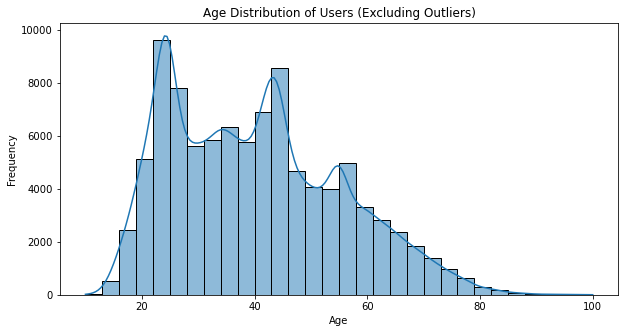

In [14]:
# Plot Age Distribution excluding outliers and NaN values
plt.figure(figsize=(10,5))
sns.histplot(users[~users['age_outlier'] & users['age'].notna()]['age'], bins=30, kde=True)
plt.title("Age Distribution of Users (Excluding Outliers)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

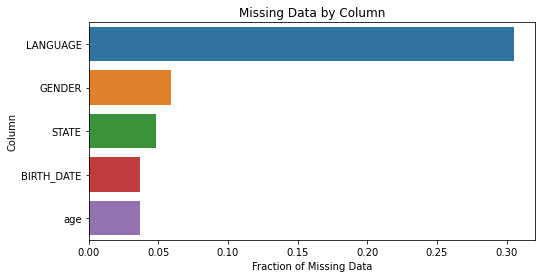

In [15]:
#Visualize Missing Data by Column
# Create a bar plot to visualize missing data by column
plt.figure(figsize=(8,4))
missing = users.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0]
sns.barplot(x=missing.values, y=missing.index)
plt.title("Missing Data by Column")
plt.xlabel("Fraction of Missing Data")
plt.ylabel("Column")
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


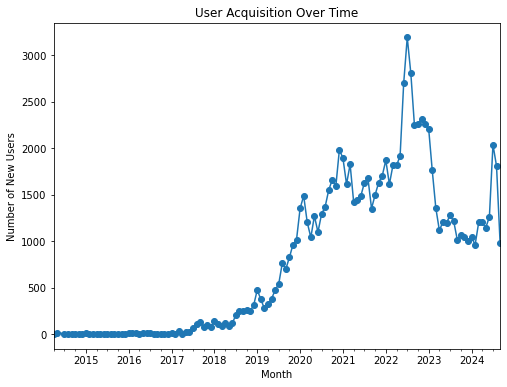

In [16]:
#Analyze User Acquisition Over Time (User Growth)
# Group by month and count users
users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE'], errors='coerce')
user_growth = users.groupby(users['CREATED_DATE'].dt.to_period('M')).size()

# Plot User Acquisition Over Time
user_growth.plot(kind='line', marker='o', figsize=(8, 6), title='User Acquisition Over Time')
plt.xlabel('Month')
plt.ylabel('Number of New Users')
plt.show()

# TRANSACATIONS DATA

In [17]:
transactions = pd.read_csv('/Users/saiprakashmadderla/fetch-data-analyst-assessment/data/transactions.csv')
transactions.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


In [18]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RECEIPT_ID      50000 non-null  object 
 1   PURCHASE_DATE   50000 non-null  object 
 2   SCAN_DATE       50000 non-null  object 
 3   STORE_NAME      50000 non-null  object 
 4   USER_ID         50000 non-null  object 
 5   BARCODE         44238 non-null  float64
 6   FINAL_QUANTITY  50000 non-null  object 
 7   FINAL_SALE      50000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.1+ MB


In [19]:
# Check for missing values
missing_values = transactions.isnull().sum()
missing_values

RECEIPT_ID           0
PURCHASE_DATE        0
SCAN_DATE            0
STORE_NAME           0
USER_ID              0
BARCODE           5762
FINAL_QUANTITY       0
FINAL_SALE           0
dtype: int64

In [20]:
# Check for duplicates
duplicates = transactions.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 171


In [21]:
#Handle missing values (drop)
# For simplicity, we can drop rows where 'BARCODE' is missing
transactions = transactions.dropna(subset=['BARCODE'])

In [22]:
transactions['PURCHASE_DATE'] = pd.to_datetime(transactions['PURCHASE_DATE'], errors='coerce')
transactions['SCAN_DATE'] = pd.to_datetime(transactions['SCAN_DATE'], errors='coerce')

In [23]:
missing_barcodes_by_store = transactions[transactions['BARCODE'].isnull()]['STORE_NAME'].value_counts()
missing_barcodes_by_user = transactions[transactions['BARCODE'].isnull()]['USER_ID'].value_counts().head()

In [24]:
#Dropping the excat duplicates
transactions = transactions.drop_duplicates()
transactions

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539000+00:00,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813000+00:00,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468000+00:00,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549000+00:00,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,
5,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247000+00:00,WALMART,5dcc6c510040a012b8e76924,6.811314e+11,zero,1.46
...,...,...,...,...,...,...,...,...
49995,b5cd61a9-8033-4913-a5c4-fb3f65e3a321,2024-08-21,2024-08-31 14:13:08.634000+00:00,TARGET,6154bcf098f885648de2f299,8.523911e+10,2.00,1.18
49996,e1b2f634-c9ad-4152-b662-4b22efc25862,2024-08-11,2024-08-11 18:15:56.736000+00:00,STOP & SHOP,60aa809f188b926b2244c974,4.610040e+10,1.00,2.00
49997,b07ef8dd-e444-40a2-819b-f74a3e5f1ae7,2024-07-11,2024-07-11 08:03:25.816000+00:00,WALMART,60bd26e83dc3b13a15c5f4e7,6.466300e+11,1.00,20.96
49998,42475141-bef4-4df2-aa37-72577e2512bb,2024-06-18,2024-06-18 19:57:32.211000+00:00,MARKET BASKET,6169912fac47744405af62b7,4.180050e+10,1.00,3.00


In [25]:
#Remove invalid transactions (FINAL_QUANTITY = 0 & FINAL_SALE = 0)
#Replace 'zero' with 0 and convert to float
transactions['FINAL_QUANTITY'] = pd.to_numeric(transactions['FINAL_QUANTITY'].replace('zero', 0), errors='coerce')
transactions['FINAL_SALE'] = pd.to_numeric(transactions['FINAL_SALE'].replace('zero', 0), errors='coerce')
transactions = transactions[(transactions['FINAL_QUANTITY'] > 0) & (transactions['FINAL_SALE'] > 0)]


In [26]:
#Check for duplicates based on RECEIPT_ID
duplicates_receipt = transactions[transactions.duplicated(subset=['RECEIPT_ID'], keep=False)]
print(f"Duplicates in RECEIPT_ID: {duplicates_receipt.shape[0]}")


Duplicates in RECEIPT_ID: 694


In [27]:
#Check for repeated items within the same RECEIPT_ID (same BARCODE)
duplicate_items_within_receipt = duplicates_receipt[duplicates_receipt.duplicated(subset=['RECEIPT_ID', 'BARCODE'], keep=False)]
print(f"Total rows with repeated items within the same receipt: {duplicate_items_within_receipt.shape[0]}")

Total rows with repeated items within the same receipt: 30


In [28]:
#Check for inconsistencies (same RECEIPT_ID with different dates or users)
receipt_variations = duplicates_receipt.groupby('RECEIPT_ID').agg({
    'SCAN_DATE': pd.Series.nunique,
    'PURCHASE_DATE': pd.Series.nunique,
    'USER_ID': pd.Series.nunique
}).reset_index()

multiple_variations = receipt_variations[(receipt_variations['SCAN_DATE'] > 1) |
                                         (receipt_variations['PURCHASE_DATE'] > 1) |
                                         (receipt_variations['USER_ID'] > 1)]

print(f"Total receipts with variations in dates or users: {multiple_variations.shape[0]}")


Total receipts with variations in dates or users: 0


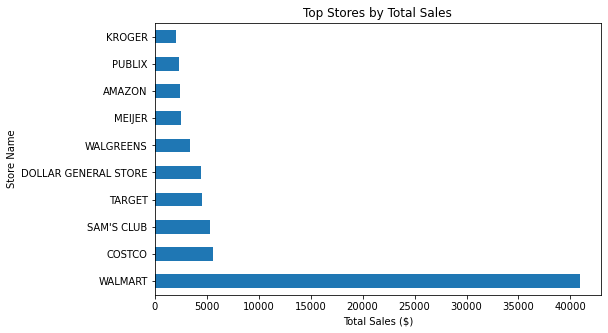

In [29]:
store_sales = transactions.groupby('STORE_NAME')['FINAL_SALE'].sum().sort_values(ascending=False)
store_sales.head(10).plot(kind='barh', figsize=(8, 5), title='Top Stores by Total Sales')
plt.xlabel('Total Sales ($)')
plt.ylabel('Store Name')
plt.show()

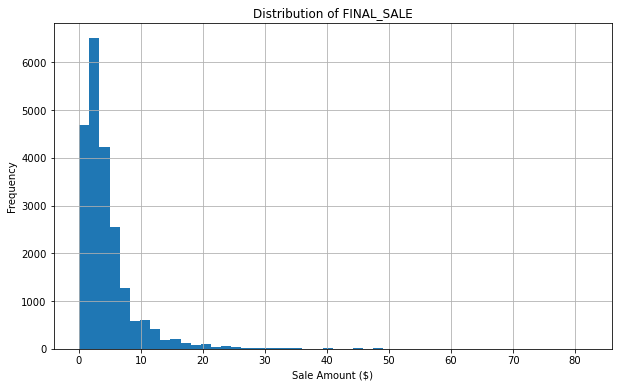

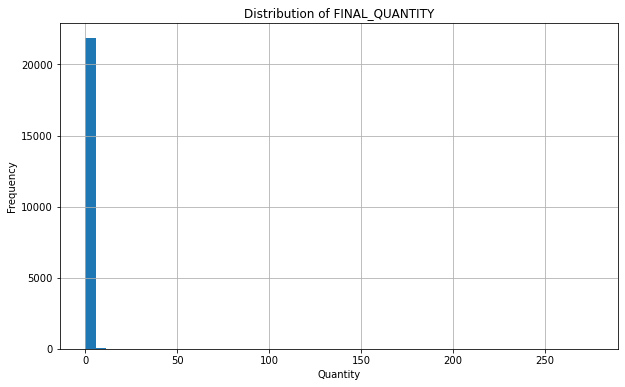

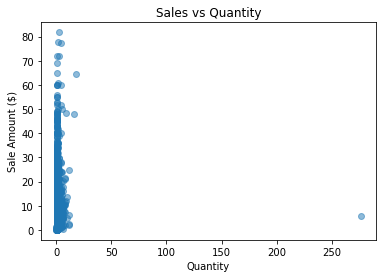

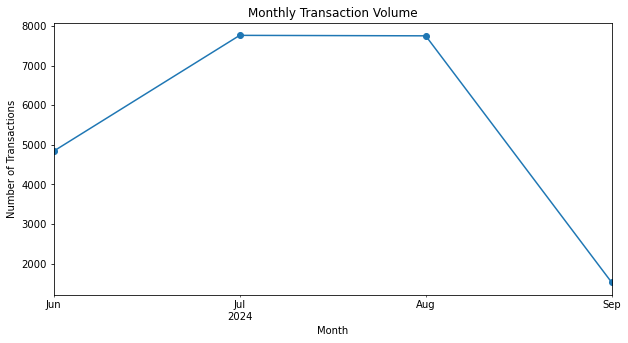

In [30]:
# Histogram of final sale amounts
transactions['FINAL_SALE'].hist(bins=50, figsize=(10, 6))
plt.title('Distribution of FINAL_SALE')
plt.xlabel('Sale Amount ($)')
plt.ylabel('Frequency')
plt.show()

# Histogram of quantities
transactions['FINAL_QUANTITY'].hist(bins=50, figsize=(10, 6))
plt.title('Distribution of FINAL_QUANTITY')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# Scatter plot for sale vs. quantity to identify any outliers
plt.scatter(transactions['FINAL_QUANTITY'], transactions['FINAL_SALE'], alpha=0.5)
plt.title('Sales vs Quantity')
plt.xlabel('Quantity')
plt.ylabel('Sale Amount ($)')
plt.show()

# Transcation volume over time 
transaction_trend = transactions.groupby(transactions['PURCHASE_DATE'].dt.to_period('M')).size()
transaction_trend.plot(kind='line', marker='o', figsize=(10, 5), title='Monthly Transaction Volume')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

# Product Data

In [31]:
products = pd.read_csv('/Users/saiprakashmadderla/fetch-data-analyst-assessment/data/products.csv')
products.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11


In [32]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CATEGORY_1    845441 non-null  object 
 1   CATEGORY_2    844128 non-null  object 
 2   CATEGORY_3    784986 non-null  object 
 3   CATEGORY_4    67459 non-null   object 
 4   MANUFACTURER  619078 non-null  object 
 5   BRAND         619080 non-null  object 
 6   BARCODE       841527 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.2+ MB


In [33]:
# Check missing values
missing_vals = products.isnull().sum()
print("\nMissing Values:\n", missing_vals)


Missing Values:
 CATEGORY_1         111
CATEGORY_2        1424
CATEGORY_3       60566
CATEGORY_4      778093
MANUFACTURER    226474
BRAND           226472
BARCODE           4025
dtype: int64


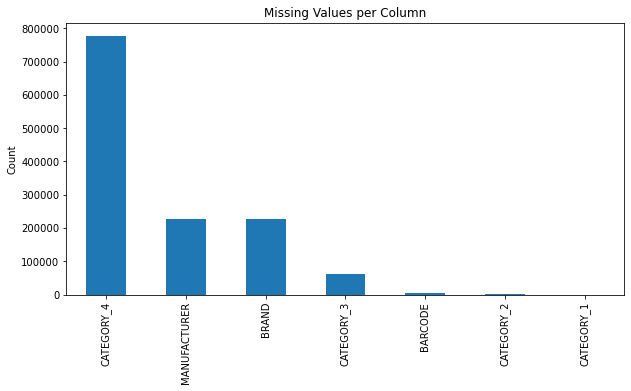

In [34]:
#Visualize missing data
missing_vals[missing_vals > 0].sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title="Missing Values per Column")
plt.ylabel("Count")
plt.show()

#### Product Data – Missing Values Summary

The dataset shows several missing fields that could impact product-level analysis:

1. CATEGORY_4: Missing in ~778K records, suggesting this field may be optional or inconsistently used.

2. CATEGORY_3 and CATEGORY_2: Also have significant gaps, which may limit multi-level category analysis.

3. MANUFACTURER and BRAND: Missing in ~226K records each, making brand-level and manufacturer insights less reliable.

4. BARCODE: 4,025 missing values may affect product matching or transaction linking.

These gaps suggest potential data entry issues or incomplete integration across product sources. Further cleaning or clarification from data owners may be needed for accurate downstream analysis.

In [35]:
#Check for duplicates
duplicate_rows = products.duplicated().sum()
print(f"\nExact duplicate rows: {duplicate_rows}")


Exact duplicate rows: 215


In [36]:
#Remove duplicates
products.drop_duplicates(inplace=True)

In [37]:
#Drop rows with missing BARCODE (critical for joins)
products = products[products['BARCODE'].notnull()]
print("Shape after dropping null BARCODEs:", products.shape)

Shape after dropping null BARCODEs: (841369, 7)


In [38]:
#Clean and standardize text fields
text_columns = ['CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'MANUFACTURER', 'BRAND']
for col in text_columns:
    products[col] = products[col].astype(str).str.strip().str.title()


In [39]:
#Replace 'Nan' strings with proper NaN
products.replace('Nan', pd.NA, inplace=True)

In [40]:
#Final null check after cleaning
print("\nMissing values after cleaning:\n", products.isnull().sum())


Missing values after cleaning:
 CATEGORY_1         111
CATEGORY_2         661
CATEGORY_3       58714
CATEGORY_4      774135
MANUFACTURER    226217
BRAND           226215
BARCODE              0
dtype: int64


In [41]:
#Summary statistics for categorical columns
for col in ['CATEGORY_1', 'CATEGORY_2','CATEGORY_3','CATEGORY_4', 'BRAND', 'MANUFACTURER']:
    print(f"\nTop values for {col}:")
    print(products[col].value_counts(dropna=True).head(5))


Top values for CATEGORY_1:
Health & Wellness        510388
Snacks                   323039
Beverages                  3977
Pantry                      867
Apparel & Accessories       840
Name: CATEGORY_1, dtype: int64

Top values for CATEGORY_2:
Candy                     120635
Hair Care                 111169
Medicines & Treatments     98734
Bath & Body                81131
Skin Care                  62185
Name: CATEGORY_2, dtype: int64

Top values for CATEGORY_3:
Confection Candy                 56914
Vitamins & Herbal Supplements    55632
Chocolate Candy                  47561
Hair Styling Products            20406
Reading Glasses                  20392
Name: CATEGORY_3, dtype: int64

Top values for CATEGORY_4:
Lip Balms                      9712
Already Popped Popcorn         6956
Sleep Aids                     4968
Hair Brushes & Combs           4720
Women'S Shaving Gel & Cream    3871
Name: CATEGORY_4, dtype: int64

Top values for BRAND:
Rem Brand          20813
Brand Not Known 

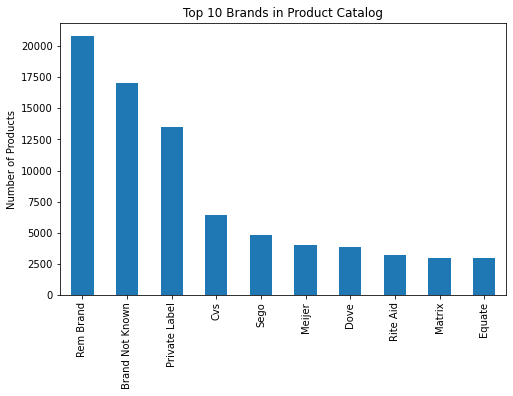

In [42]:
# Lets view some charts - Top 10 Brands
top_brands = products['BRAND'].value_counts().head(10)
top_brands.plot(kind='bar', figsize=(8, 5), title="Top 10 Brands in Product Catalog")
plt.ylabel("Number of Products")
plt.show()

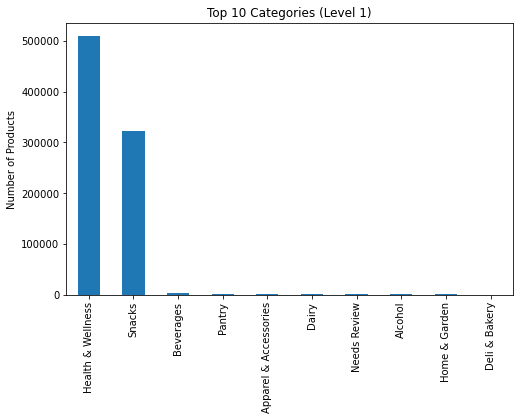

In [43]:
# Top 10 Category_1
top_cat1 = products['CATEGORY_1'].value_counts().head(10)
top_cat1.plot(kind='bar', figsize=(8, 5), title="Top 10 Categories (Level 1)")
plt.ylabel("Number of Products")
plt.show()

# Second : Provide SQL Queries

Closed-Ended Questions 

1.What are the top 5 brands by receipts scanned among users 21 and over?

In [44]:
import sqlite3
from tabulate import tabulate

In [45]:
# Create an in-memory SQLite database
conn = sqlite3.connect(":memory:")

# Save each DataFrame to the SQLite DB as tables
users.to_sql("users", conn, index=False, if_exists="replace")
transactions.to_sql("transactions", conn, index=False, if_exists="replace")
products.to_sql("products", conn, index=False, if_exists="replace")


841369

In [46]:
query1 = '''
SELECT p.BRAND, COUNT(DISTINCT t.RECEIPT_ID) AS Receipt_Count
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE u.age >= 21 AND p.BRAND IS NOT NULL AND TRIM(p.BRAND) != ''
GROUP BY p.BRAND
ORDER BY Receipt_Count DESC
LIMIT 5;
'''
result1 = pd.read_sql_query(query1, conn)
print("Top 5 Brands by Receipts Scanned (Age 21+):")
print(tabulate(result1, headers='keys', tablefmt='psql'))

Top 5 Brands by Receipts Scanned (Age 21+):
+----+-----------------+-----------------+
|    | BRAND           |   Receipt_Count |
|----+-----------------+-----------------|
|  0 | Nerds Candy     |               3 |
|  1 | Dove            |               3 |
|  2 | Trident         |               2 |
|  3 | Sour Patch Kids |               2 |
|  4 | Meijer          |               2 |
+----+-----------------+-----------------+


2.What are the top 5 brands by sales among users that have had their account for at least six months?

In [47]:
query2 = '''
SELECT p.BRAND, SUM(t.FINAL_SALE) AS Total_Sales
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE u.age >= 21
AND DATE('now') >= DATE(u.CREATED_DATE, '+6 months')
GROUP BY p.BRAND
ORDER BY Total_Sales DESC
LIMIT 5;
'''

# Run the query and store result in a DataFrame
result2 = pd.read_sql_query(query2, conn)

# Print in a clean table format
print("Top 5 Brands by Sales Among Users with Accounts for at Least Six Months:")
print(tabulate(result2, headers='keys', tablefmt='pretty'))


Top 5 Brands by Sales Among Users with Accounts for at Least Six Months:
+---+-------------+-------------+
|   |    BRAND    | Total_Sales |
+---+-------------+-------------+
| 0 |     Cvs     |    72.0     |
| 1 |    Dove     |    30.91    |
| 2 |   Trident   |    23.36    |
| 3 | Coors Light |    17.48    |
| 4 |  Tresemmé   |    14.58    |
+---+-------------+-------------+


3.What is the percentage of sales in the Health & Wellness category by generation?

In [48]:
query3 = '''
WITH health_wellness_sales AS (
    SELECT t.USER_ID, t.FINAL_SALE, u.age
    FROM transactions t
    JOIN users u ON t.USER_ID = u.ID
    JOIN products p ON t.BARCODE = p.BARCODE
    WHERE p.CATEGORY_1 = 'Health & Wellness'
),
total_sales AS (
    SELECT SUM(FINAL_SALE) AS total
    FROM transactions
)
SELECT 
    CASE 
        WHEN age BETWEEN 18 AND 34 THEN 'Generation Z / Millennial'
        WHEN age BETWEEN 35 AND 54 THEN 'Generation X'
        WHEN age >= 55 THEN 'Baby Boomers'
        ELSE 'Unknown'
    END AS Generation,
    ROUND(SUM(health_wellness_sales.FINAL_SALE) / total_sales.total * 100, 2) AS Percentage_of_Sales
FROM health_wellness_sales
JOIN total_sales
GROUP BY Generation
ORDER BY Percentage_of_Sales DESC;
'''

# Run query and get DataFrame
result3 = pd.read_sql_query(query3, conn)

# Print the result in table format
print("Percentage of Sales in the Health & Wellness Category by Generation:")
print(tabulate(result3, headers='keys', tablefmt='pretty'))


Percentage of Sales in the Health & Wellness Category by Generation:
+---+---------------------------+---------------------+
|   |        Generation         | Percentage_of_Sales |
+---+---------------------------+---------------------+
| 0 |       Baby Boomers        |        0.09         |
| 1 |       Generation X        |        0.05         |
| 2 | Generation Z / Millennial |        0.02         |
+---+---------------------------+---------------------+


In [49]:

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   ID            100000 non-null  object             
 1   CREATED_DATE  100000 non-null  datetime64[ns, UTC]
 2   BIRTH_DATE    96325 non-null   datetime64[ns]     
 3   STATE         95188 non-null   object             
 4   LANGUAGE      69492 non-null   object             
 5   GENDER        94108 non-null   object             
 6   age           96325 non-null   float64            
 7   age_outlier   100000 non-null  bool               
dtypes: bool(1), datetime64[ns, UTC](1), datetime64[ns](1), float64(1), object(4)
memory usage: 5.4+ MB


### Open Ended Question

Assumption: Power users are defined as users with the highest number of transactions and the highest total spend.

In [51]:
# 1. Fetch's Power Users: Users with the most transactions
power_users_query = """
SELECT t.USER_ID,COUNT(t.RECEIPT_ID) AS total_transactions,SUM(t.FINAL_SALE) as total_spent
FROM transactions t
WHERE t.FINAL_SALE IS NOT NULL
GROUP BY t.USER_ID
ORDER BY total_transactions DESC, total_Spent DESC
LIMIT 10;
"""
power_users = pd.read_sql_query(power_users_query, conn)

# Output the results
print("Power Users:")
display(power_users)

Power Users:


,USER_ID,total_transactions,total_spent
0,62925c1be942f00613f7365e,10,27.61
1,64063c8880552327897186a5,9,30.61
2,609af341659cf474018831fb,7,14.34
3,6327a07aca87b39d76e03864,7,12.54
4,60a5363facc00d347abadc8e,6,84.58
5,5d77d06b0d1bff4316a3ef47,6,57.21
6,653a0f40909604bae9071473,6,50.74
7,605a982894a5c74ba439e5ab,6,41.89
8,5eb59d6be7012d13941af5e2,6,34.99
9,63f1904938f010745b9a2b60,6,33.02


Which is the leading brand in the Dips & Salsa category?

In [58]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21882 entries, 25000 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   RECEIPT_ID      21882 non-null  object             
 1   PURCHASE_DATE   21882 non-null  datetime64[ns]     
 2   SCAN_DATE       21882 non-null  datetime64[ns, UTC]
 3   STORE_NAME      21882 non-null  object             
 4   USER_ID         21882 non-null  object             
 5   BARCODE         21882 non-null  float64            
 6   FINAL_QUANTITY  21882 non-null  float64            
 7   FINAL_SALE      21882 non-null  float64            
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(3), object(3)
memory usage: 1.5+ MB


In [66]:
leading_brand_query = """
SELECT p.BRAND, COUNT(t.RECEIPT_ID) AS total_sales
FROM products p
JOIN transactions t ON p.BARCODE = t.BARCODE
WHERE p.CATEGORY_2 = 'Dips & Salsa'
GROUP BY p.BRAND
ORDER BY total_sales DESC
LIMIT 1;
"""

leading_brand = pd.read_sql_query(leading_brand_query, conn)
display(leading_brand)

,BRAND,total_sales
0,Tostitos,36


At what percent has Fetch grown year over year?

In [69]:
growth_query = """
SELECT strftime('%Y', PURCHASE_DATE) AS year, COUNT(RECEIPT_ID) AS total_transactions
FROM transactions
GROUP BY year
ORDER BY year;
"""

yearly_transactions = pd.read_sql_query(growth_query, conn)

# Convert year to int and calculate YoY growth %
yearly_transactions['year'] = yearly_transactions['year'].astype(int)
yearly_transactions['growth_percent'] = yearly_transactions['total_transactions'].pct_change() * 100

display(yearly_transactions)



,year,total_transactions,growth_percent
0,2024,21882,NaN
